<a href="https://colab.research.google.com/github/Giffy/fast.ai/blob/master/Machine%20Learning/lesson3_randomforest_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# 1 Random Forest Model interpretation

## 1.0 Setup

### Google Colab setup
Installs fast.ai 0.7.0 and the required libraries to run the notebook.

Also downloads the required datasets.

In [1]:
print (" Installing FastAI libraries...")
!pip install fastai==0.7.0 > /dev/null
print ("\n Installing required libraries...")
!pip install feather > /dev/null
!pip install scikit-misc==0.1.0 > /dev/null
!pip install pdpbox==0.2.0 > /dev/null
!pip install treeinterpreter==0.2.2 > /dev/null

 Installing FastAI libraries...
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
mizani 0.5.3 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.
plotnine 0.5.1 has requirement pandas>=0.23.4, but you'll have pandas 0.22.0 which is incompatible.

 Installing required libraries...
Command "python setup.py egg_info" failed with error code 1 in /tmp/pip-install-0uytwnst/feather/


In [2]:
print ("\n Downloading train dataset...")
!wget https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/train.tar.gz
!tar xvf train.tar.gz > /dev/null


--2019-02-22 23:56:39--  https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9126495 (8.7M) [application/octet-stream]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   8.70M  --.-KB/s    in 0.1s    

2019-02-22 23:56:39 (81.5 MB/s) - ‘train.tar.gz’ saved [9126495/9126495]



In [3]:
print ("\n Downloading dataframe processed ...")
!wget https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/df_raw.tar.gz
!tar xvf df_raw.tar.gz > /dev/null


--2019-02-22 23:56:42--  https://raw.githubusercontent.com/Giffy/Personal_dataset_repository/master/df_raw.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8785385 (8.4M) [application/octet-stream]
Saving to: ‘df_raw.tar.gz’

df_raw.tar.gz       100%[===================>]   8.38M  --.-KB/s    in 0.1s    

2019-02-22 23:56:42 (81.5 MB/s) - ‘df_raw.tar.gz’ saved [8785385/8785385]



### Import libraries 

In [0]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
set_plot_sizes(12,14,16)

##1.1 Load in our data from last lesson

In [0]:
PATH = "/content/data/bulldozers/"                        # changed data path

import feather                                            # Import feather library
df_raw=feather.read_dataframe('tmp/bulldozers-raw')       # replaced:  df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [0]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [10]:
df_raw.head(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
5,1139255,10.184900,1001274,4605,121,3.0,2004,508.0,2,310G,...,18,3,353,False,False,False,False,False,False,1229558400
6,1139256,9.952278,772701,1937,121,3.0,1993,11540.0,0,790ELC,...,26,3,239,False,False,False,False,False,False,1093478400
7,1139261,10.203592,902002,3539,121,3.0,2001,4883.0,0,416D,...,17,3,321,False,False,False,False,False,False,1132185600
8,1139272,9.975808,1036251,36003,121,3.0,2008,302.0,2,430HAG,...,27,3,239,False,False,False,False,False,False,1251331200
9,1139275,11.082143,1016474,3883,121,3.0,1000,20700.0,1,988B,...,9,3,221,False,False,False,False,False,False,1186617600


# 2 Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [0]:
set_rf_samples(50000)

In [12]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

# [ 0.20574285, 0.24986059, 0.911532375, 0.88850805288434, 0.8945349]
# [ rmse train, rmse valid, train score, validation score, oob_score]

[0.20614519141261448, 0.2475631284734148, 0.9111860381453336, 0.8905489585014906, 0.8941032410933358]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [13]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.69 s, sys: 86.9 ms, total: 1.78 s
Wall time: 1.78 s


(9.242130424526199, 0.20602622155148595)

In [0]:
predy= m.predict(X_valid)  

In [15]:
print(y_valid[0])

9.104979856318357


In [16]:
print(predy[0])

9.242130424526197


When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [17]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 136 ms, sys: 140 ms, total: 276 ms
Wall time: 1.8 s


(9.242130424526199, 0.20602622155148595)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

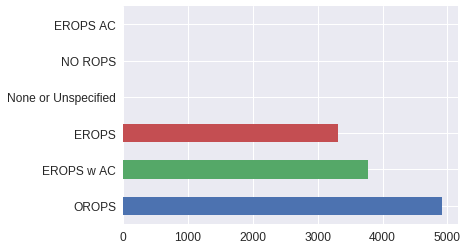

In [18]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [19]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.845233,0.274375
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.577133,0.264243
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684915,0.224948


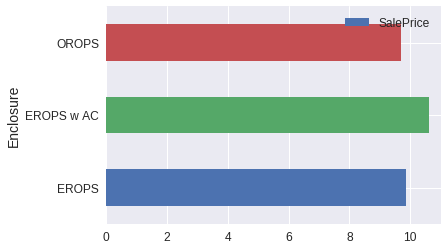

In [20]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

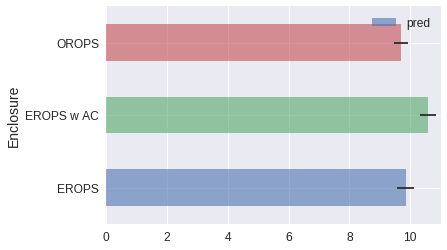

In [21]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

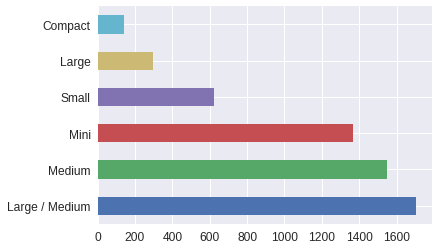

In [22]:
raw_valid.ProductSize.value_counts().plot.barh();

In [23]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.839642,0.347827
Large,10.470589,10.390436,0.357038
Large / Medium,10.691871,10.649228,0.297826
Medium,10.681511,10.621066,0.293544
Mini,9.535147,9.571277,0.249785
Small,10.324448,10.334486,0.301302


In [24]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035350
Large             0.034362
Small             0.029155
Large / Medium    0.027967
Medium            0.027638
Mini              0.026097
dtype: float64

#3 Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [25]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.176534
13,ProductSize,0.096874
37,Coupler_System,0.093742
14,fiProductClassDesc,0.083643
38,Grouser_Tracks,0.061892
2,ModelID,0.051043
63,saleElapsed,0.049911
10,fiSecondaryDesc,0.048425
19,Enclosure,0.035632
8,fiModelDesc,0.031759


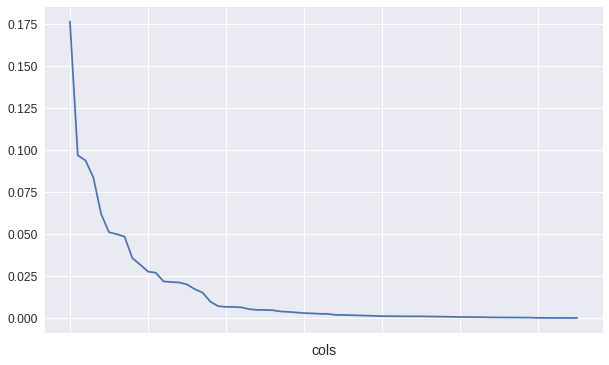

In [26]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

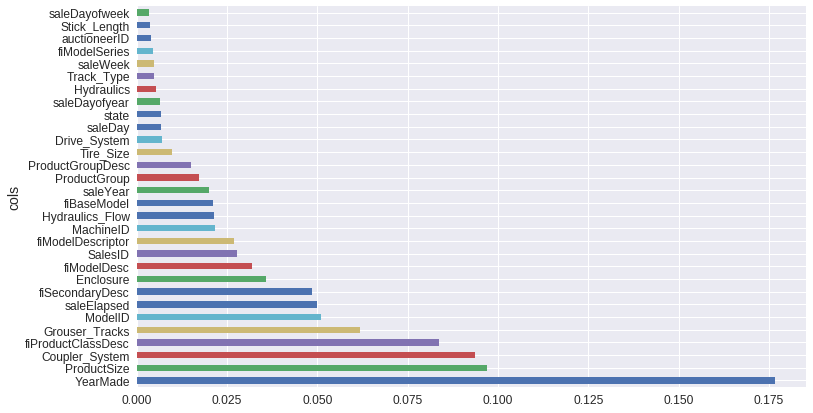

In [28]:
plot_fi(fi[:30]);

In [29]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [0]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [31]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[0.2065481130532982, 0.24504304146480257, 0.9108385157133958, 0.892765946574063, 0.8945035330942569]


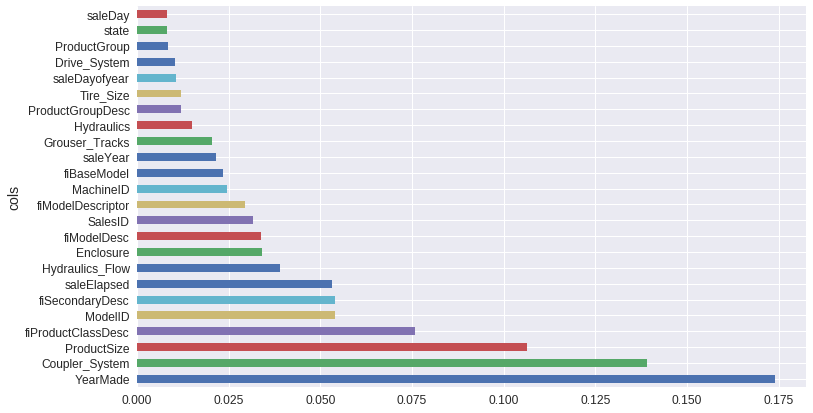

In [32]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

##3.1 One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [33]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20717288396288377, 0.2539073142586209, 0.9102983050053239, 0.8848673774470663, 0.8926393534477622]


In [34]:
df_trn2.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Differential_Type_Locking', 'Differential_Type_No Spin',
       'Differential_Type_Standard', 'Differential_Type_nan',
       'Steering_Controls_Command Control', 'Steering_Controls_Conventional',
       'Steering_Controls_Four Wheel Standard', 'Steering_Controls_No',
       'Steering_Controls_Wheel', 'Steering_Controls_nan'],
      dtype='object', length=170)

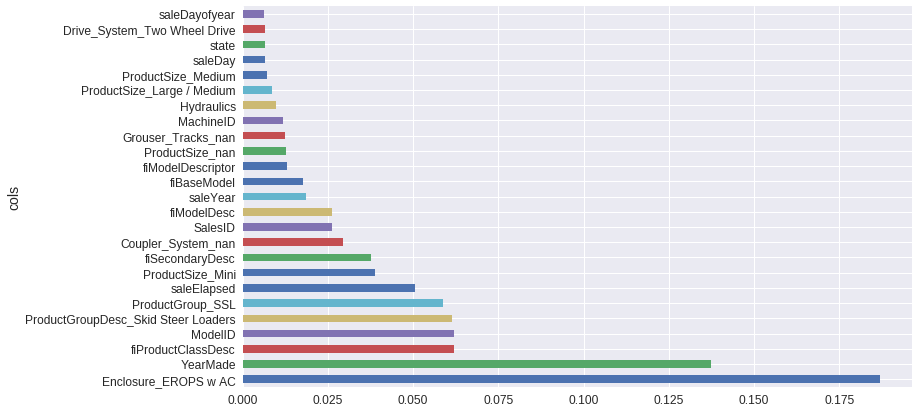

In [35]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

#4 Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [0]:
from scipy.cluster import hierarchy as hc

In [0]:
#scipy.stats.spearmanr(df_keep)

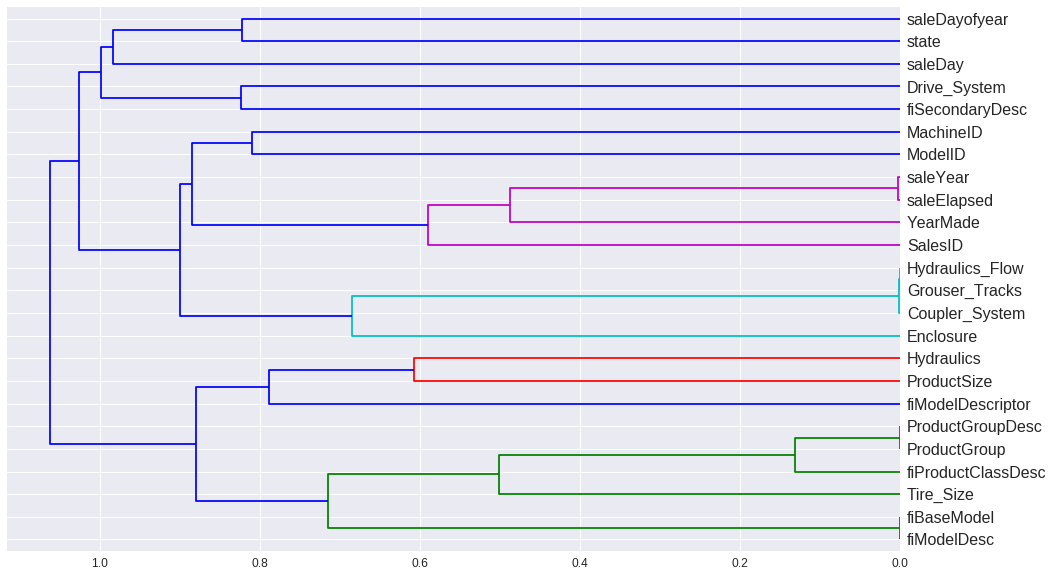

In [38]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr) #lo convertimos a una matriz de distancia
z = hc.linkage(corr_condensed, method='average') #creamos algo que nos diga que esta conectado con el resto de cosas de forma jerarquica
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [40]:
get_oob(df_keep)

0.8898912359281818

Now we try removing each variable one at a time.

In [41]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8899664520541946
saleElapsed 0.8866832291982287
fiModelDesc 0.8890932241062126
fiBaseModel 0.8883674314103798
Grouser_Tracks 0.8898593407151452
Coupler_System 0.8902225013153133


It looks like we can try one from each group for removal. Let's see what that does.

In [42]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8885257748558013

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [0]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
#np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [0]:
#keep_cols = np.load('tmp/keep_cols.npy')
#df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [0]:
reset_rf_samples()

In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12571750138749618, 0.22624001491263904, 0.966968651207943, 0.9085914509208757, 0.9086935231163769]


#5 Partial dependence

In [0]:
from pdpbox import pdp
from plotnine import *

In [0]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [0]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

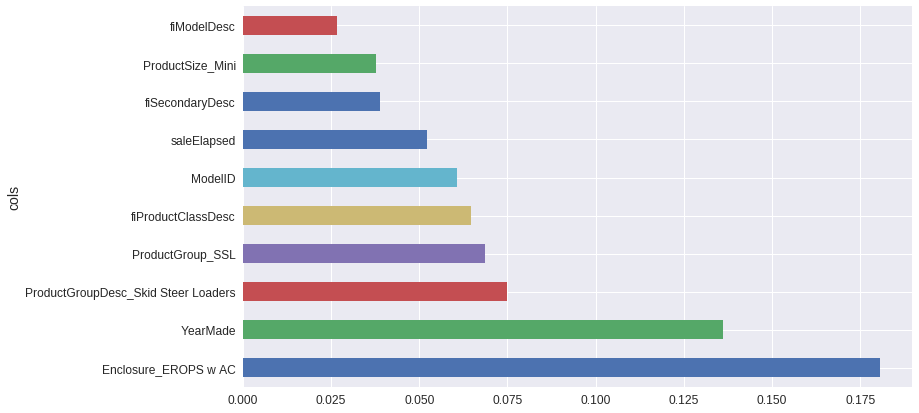

In [51]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


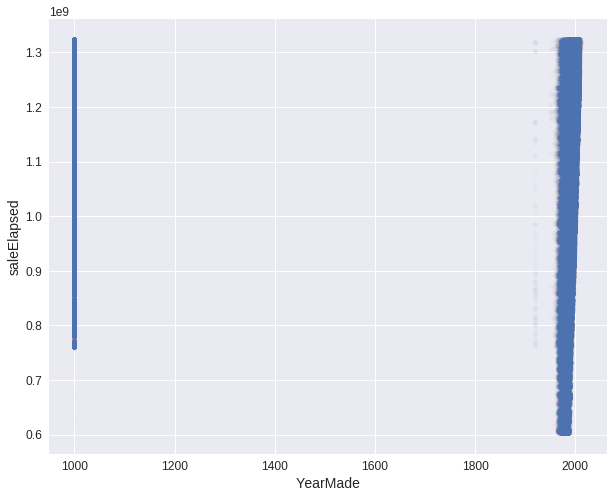

In [52]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [0]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500) #get_sample toma un sample random , 500 puntos

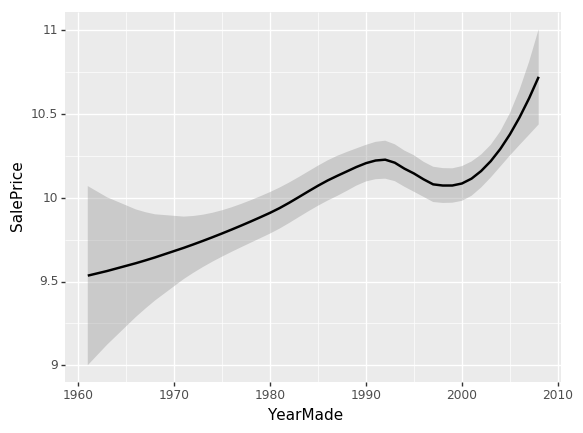

<ggplot: (8737357170629)>

In [54]:
import skmisc
#Crear un plot de este dataframe
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess') #add chart elements, pequeñas regresiones lineales en 
#cada subset del grafico, se=True muestra un intervalo de confianza. locally weighted regression ideal para mini regresiones

In [0]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [0]:
# Partial dependence plot
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)   #random forest para predecir
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f252ea6c358>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f25312b6160>})

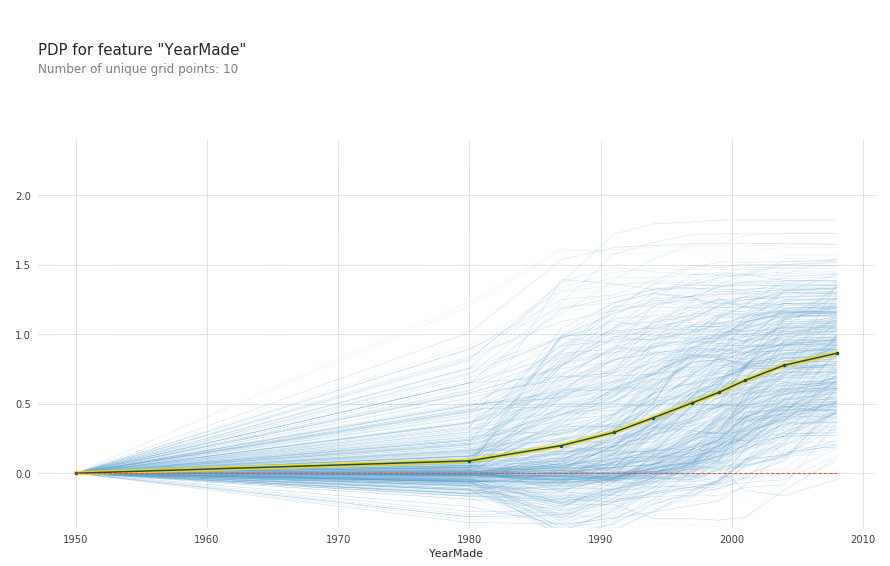

In [57]:
plot_pdp('YearMade') #plot all 500 samples predictions

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f25193d4390>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2519464940>})

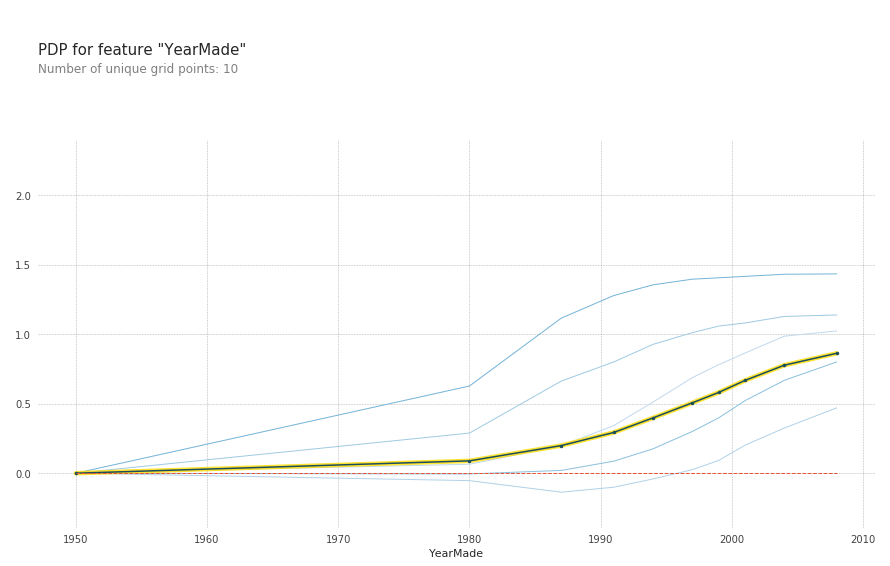

In [58]:
plot_pdp('YearMade', clusters=5)

In [0]:
##  Line added to draw pdp_interact properly
!sed -i '251s/.* /    inter_ax.clabel(c2, /g' /usr/local/lib/python3.6/dist-packages/pdpbox/pdp_plot_utils.py

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2519476d68>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2518b9f7b8>})

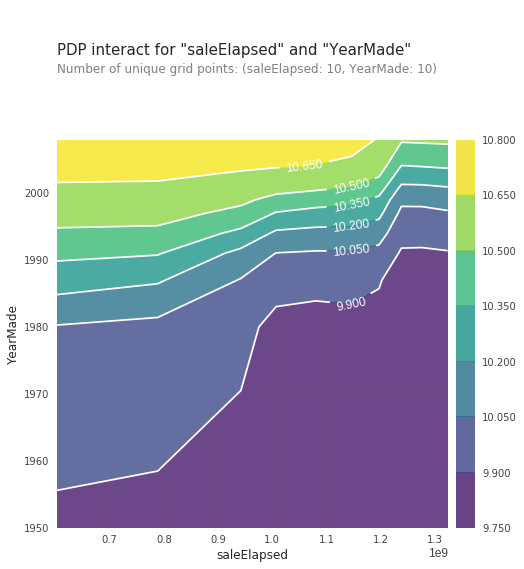

In [60]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f2530976908>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f253090e588>})

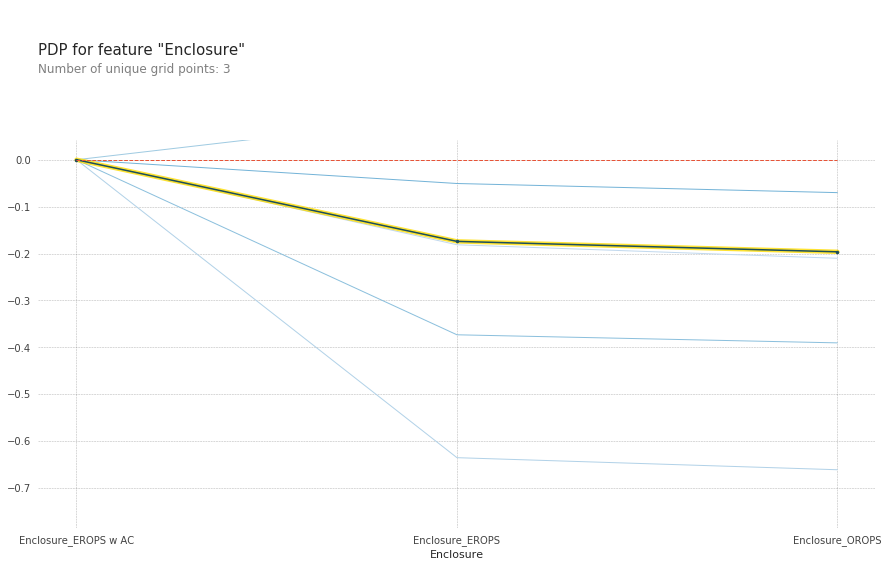

In [61]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [0]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

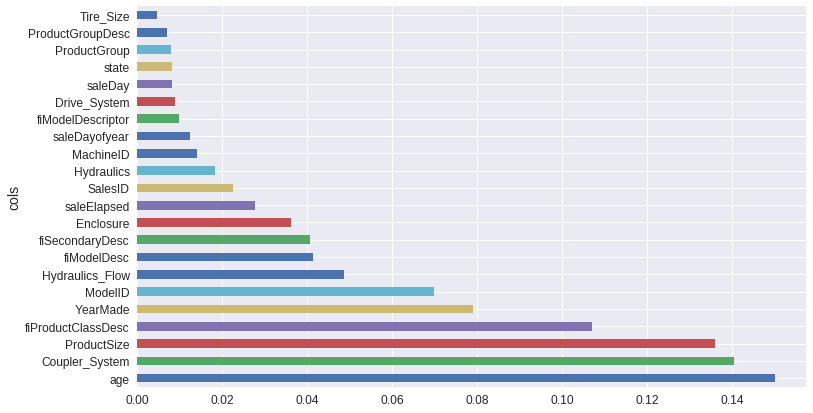

In [63]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

#6 Tree interpreter

In [0]:
from treeinterpreter import treeinterpreter as ti

In [0]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [66]:
row = X_valid.values[None,0]; row #permite interpretar filas, fila 0 (muestra columnas)

array([[      1999,          5,          0,         17,        665, 1284595200,          0,          1,
              3232,    4364751,          0,    2300944,          0,          4,          4,          0,
                 0,         16,         35,        259,         12,         11]])

In [0]:
prediction, bias, contributions = ti.predict(m, row) #obtenemos prediccion, el bias el promedio de los precios en todo el dataset
#contributions

In [68]:
prediction[0], bias[0]

(array([9.35551]), 10.105867632179969)

In [0]:
idxs = np.argsort(contributions[0])

In [70]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5260721469717),
 ('age', 11, -0.13781094612821887),
 ('fiModelDesc', 'KX1212', -0.11308113271403127),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.08956471124529175),
 ('fiSecondaryDesc', nan, -0.060238390620763214),
 ('Enclosure', 'EROPS', -0.027207192010740223),
 ('saleElapsed', 1284595200, -0.020508107579874667),
 ('saleDayofyear', 259, -0.012014013264550583),
 ('Tire_Size', nan, -0.007093773895098643),
 ('SalesID', 4364751, -0.0068862821748395305),
 ('MachineID', 2300944, -0.005312695145462065),
 ('saleDay', 16, -0.0001378155212554688),
 ('state', 'Ohio', 0.0021086811891397605),
 ('ProductGroupDesc', 'Track Excavators', 0.003910439612505856),
 ('fiModelDescriptor', nan, 0.004748726105965284),
 ('Drive_System', nan, 0.005378973788591734),
 ('ProductGroup', 'TEX', 0.0055772818519301826),
 ('Hydraulics', 'Standard', 0.00561821329518426),
 ('Hydraulics_Flow', nan, 0.021229334583728977),
 ('ModelID', 665, 0.03520923676

In [71]:
contributions[0].sum()

-0.7503593257407518

#7 Extrapolation

In [0]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999875350576504

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
10,SalesID,0.805285
6,saleElapsed,0.130995
12,MachineID,0.056159
5,ModelID,0.002620
0,YearMade,0.001649
9,fiModelDesc,0.001441
15,Hydraulics,0.000532
18,saleDayofyear,0.000401
7,fiSecondaryDesc,0.000196
19,Track_Type,0.000152


In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [0]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [0]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [0]:
x.drop(feats, axis=1, inplace=True)

In [0]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.978747273293861

In [0]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.238309
0,YearMade,0.187763
15,saleDayofyear,0.150742
5,ModelID,0.079675
8,fiModelDesc,0.063432
13,saleDay,0.058101
14,state,0.053377
3,fiProductClassDesc,0.033025
6,fiSecondaryDesc,0.024288
7,Enclosure,0.020541


In [0]:
set_rf_samples(50000)

In [0]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofyear']

In [0]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20764353427241605, 0.24682314455181156, 0.9098902778082658, 0.8912022946097362, 0.893300131508572]


In [0]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.20925790738349365, 0.24625153151347023, 0.9084836728680739, 0.8917056361786023, 0.8923108426079902]
saleElapsed
[0.2143900452999045, 0.25431630564270324, 0.9039396735579933, 0.8844961697452939, 0.8868701201663612]
MachineID
[0.2067709542190065, 0.24583073682010026, 0.9106460223821458, 0.892075426844145, 0.8950322108759701]
age
[0.20924021737330106, 0.24873820870424823, 0.9084991452232224, 0.8895074545087767, 0.8919837231936155]
YearMade
[0.20886527885867628, 0.25056904809988906, 0.9088267730320323, 0.8878749059760478, 0.8923910637501954]
saleDayofyear
[0.20876748554363075, 0.24316110528944887, 0.9089121299169627, 0.8944067415911592, 0.8928700931428144]


In [0]:
reset_rf_samples()

In [0]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13856267286291357, 0.21924532013923015, 0.9598738649397351, 0.9141562585282896, 0.9088338566397096]


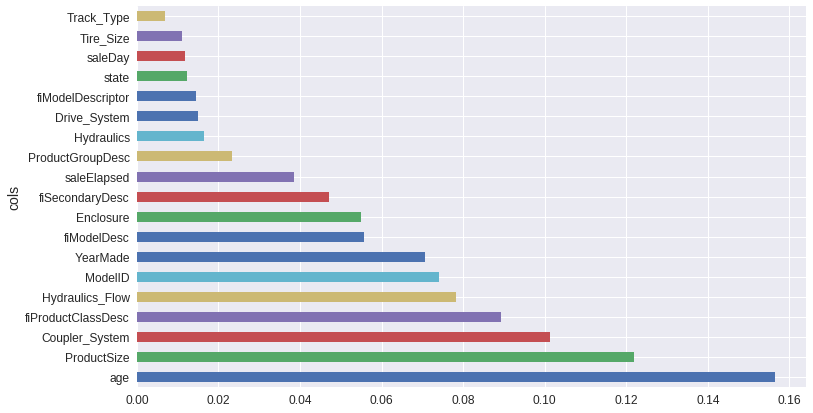

In [0]:
plot_fi(rf_feat_importance(m, X_train));

In [0]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

#8 Our final model!

In [0]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 5min 5s, sys: 2.59 s, total: 5min 8s
Wall time: 2min 42s
[0.08007243580406781, 0.2112569578430495, 0.9866001200973997, 0.9202978536273234, 0.9146555757443343]
